In [ ]:
!pip install tensorflow-gpu==2.0.0-rc1

In [3]:
import tensorflow as tf
import matplotlib.pyplot as plt
tf.__version__

'2.0.0-rc1'

## Plot Accuracy and Load Data

In [ ]:
def plot_loss_history(histories, key='loss'):
  plt.figure(figsize=(8,5))

  for name, history in histories:
    val = plt.plot(history.epoch, history.history['val_'+key],
                   '--', label=name.title()+' Val')
    plt.plot(history.epoch, history.history[key], color=val[0].get_color(),
             label=name.title()+' Train')

  plt.xlabel('Epochs')
  plt.ylabel(key.replace('_',' ').title())
  plt.legend()

  plt.xlim([0,max(history.epoch)])

In [ ]:
def plot_accuracy_history(histories, key='accuracy'):
  plt.figure(figsize=(8,5))

  for name, history in histories:
    val = plt.plot(history.epoch, history.history['val_'+key],
                   '--', label=name.title()+' Val')
    plt.plot(history.epoch, history.history[key], color=val[0].get_color(),
             label=name.title()+' Train')

  plt.xlabel('Epochs')
  plt.ylabel(key.replace('_',' ').title())
  plt.legend()

  plt.xlim([0,max(history.epoch)])

## MNIST

#### Load Data and Reshape

In [ ]:
# load data
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# reshape
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)

# Making sure that the values are float so that we can get decimal points after division
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

In [12]:
print('x_train shape:', x_train.shape)
print('Number of images in x_train', x_train.shape[0])
print('Number of images in x_test', x_test.shape[0])

x_train shape: (60000, 28, 28, 1)
Number of images in x_train 60000
Number of images in x_test 10000


#### One-hot Encoding and Normalize

In [ ]:
# one-hot encoding
y_train = tf.keras.utils.to_categorical(y_train)
y_test = tf.keras.utils.to_categorical(y_test)

# normalize -1~1
x_train = (x_train-127.5)/127.5
x_test = (x_test-127.5)/127.5

# validation
x_val = x_train[-1000:]
y_val = y_train[-1000:]
x_train = x_train[:-1000]
y_train = y_train[:-1000]

#### Compare baseline model with dropout model, l2 model

In [24]:
baseline_model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu', input_shape=(28,28,1)),
    tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
    tf.keras.layers.AvgPool2D((2,2)),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')    
])
baseline_model.summary()
optimizer = tf.keras.optimizers.Adam(learning_rate=5e-4)
baseline_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
baseline_history= baseline_model.fit(x_train, y_train, epochs=30, batch_size=64, validation_data=(x_val, y_val))

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_14 (Conv2D)           (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 28, 28, 64)        18496     
_________________________________________________________________
average_pooling2d_7 (Average (None, 14, 14, 64)        0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 12544)             0         
_________________________________________________________________
dense_14 (Dense)             (None, 128)               1605760   
_________________________________________________________________
dense_15 (Dense)             (None, 10)                1290      
Total params: 1,625,866
Trainable params: 1,625,866
Non-trainable params: 0
____________________________________________

In [25]:
dpt_model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu', input_shape=(28,28,1)),
    tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
    tf.keras.layers.AvgPool2D((2,2)),
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(10, activation='softmax')    
])
dpt_model.summary()
optimizer = tf.keras.optimizers.Adam(learning_rate=5e-4)
dpt_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
# model.fit(x_train, y_train, epochs=10, validation_data=(x_test, y_test))
dpt_model_history = dpt_model.fit(x_train, y_train, epochs=30, batch_size=64, validation_data=(x_val, y_val))

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 28, 28, 64)        18496     
_________________________________________________________________
average_pooling2d_8 (Average (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 12544)             0         
_________________________________________________________________
dense_16 (Dense)             (None, 128)               1605760   
_________________________________________________________________
dropout_5 (Dropout)          (None, 128)              

In [26]:
l2_model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu', input_shape=(28,28,1)),
    tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
    tf.keras.layers.AvgPool2D((2,2)),
#     tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, kernel_regularizer=tf.keras.regularizers.l2(0.001), activation='relu'),
#     tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(10, activation='softmax')    
])
l2_model.summary()
optimizer = tf.keras.optimizers.Adam(learning_rate=5e-4)
l2_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
# model.fit(x_train, y_train, epochs=10, validation_data=(x_test, y_test))
l2_model_history = l2_model.fit(x_train, y_train, epochs=30, batch_size=64, validation_data=(x_val, y_val))

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 28, 28, 64)        18496     
_________________________________________________________________
average_pooling2d_9 (Average (None, 14, 14, 64)        0         
_________________________________________________________________
flatten_9 (Flatten)          (None, 12544)             0         
_________________________________________________________________
dense_18 (Dense)             (None, 128)               1605760   
_________________________________________________________________
dense_19 (Dense)             (None, 10)                1290      
Total params: 1,625,866
Trainable params: 1,625,866
Non-trainable params: 0
____________________________________________

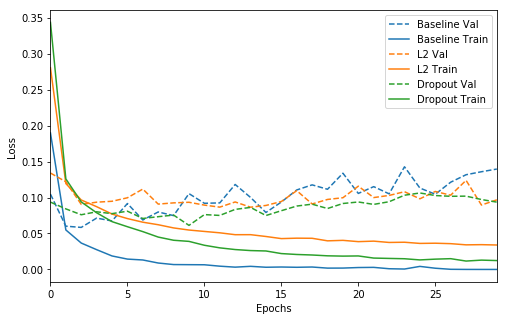

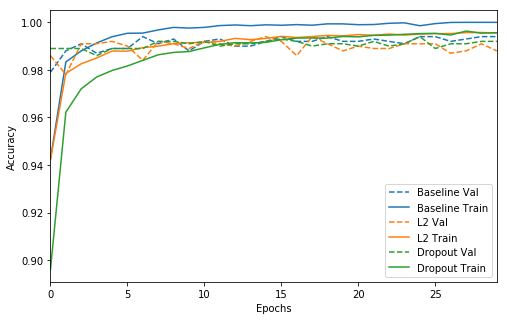

In [27]:
plot_loss_history([
    ('baseline', baseline_history),
    ('l2', l2_model_history),
    ('dropout', dpt_model_history)
])
plot_accuracy_history([
    ('baseline', baseline_history),
    ('l2', l2_model_history),
    ('dropout', dpt_model_history)
])

In [28]:
baseline_result = baseline_model.evaluate(x_test,y_test,batch_size=64)
dpt_result = dpt_model.evaluate(x_test,y_test,batch_size=64)
l2_result = l2_model.evaluate(x_test,y_test,batch_size=64)

10000/1 [===============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

In [29]:
print("baseline evaluate result: ", baseline_result)
print("dropout evaluate result: ", dpt_result)
print("L2 evaluate result: ", l2_result)

baseline evaluate result:  [0.055443637633612784, 0.991]
dropout evaluate result:  [0.027075552259491497, 0.9933]
L2 evaluate result:  [0.06196377725303173, 0.9878]
